In [61]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
%matplotlib inline

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
#device = torch.device(device)
datafolder = './data/FMNIST'

fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [62]:
class FMINSTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
        
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)
    
def get_data():
    train = FMINSTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
        ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


In [63]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [77]:
model, loss_fn, optimizer = get_model()
trn_dl = get_data()

losses, accuracies = [], []

for epoch in range(5):
    print(f'Epoch: {epoch}')
    epoch_losses, epoch_accuracies = [], []
    print('Training cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='')
        x, y = batch
        #print(f'\tTraing cicle: ix  = {ix}')
        #print(f'\tTraing cicle: x   = {x}')
        #print(f'\tTraing cicle: y   = {y}')
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
        if ix>10: break
    
    epoch_loss = np.array(epoch_losses).mean()
        
    print('Accuracy cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='')
        x, y = batch
        #print(f'\tAccuracy cicle: ix    = {ix}')
        #print(f'\tAccuracy cicle: batch = {batch}')
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
        if ix>10: break
            
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Epoch: 0
Training cicle: ............Accuracy cicle: ............Epoch: 1
Training cicle: ............Accuracy cicle: ............Epoch: 2
Training cicle: ............Accuracy cicle: ............Epoch: 3
Training cicle: ............Accuracy cicle: ............Epoch: 4
Training cicle: ............Accuracy cicle: ............

In [78]:
import platform
print(f'Platform : {platform.platform()}')
print(f'Torch MPS: {torch.has_mps}')
print(losses)

Platform : macOS-12.6-arm64-arm-64bit
Torch MPS: True
[inf, inf, inf, 2.5215240319569907, 2.3120080729325614]


/var/folders/44/sqmxmlfx5k383gls301l5s100000gn/T/ipykernel_29941/2314771950.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


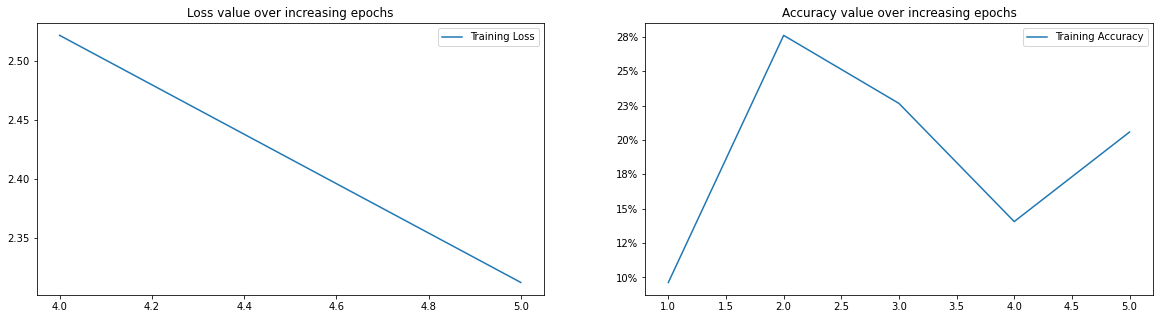

In [80]:
epochs = np.arange(5) + 1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()